# Interpolatiing Barium Initial field

In [99]:
import sys
sys.path.insert(0, '_libs/')

In [100]:
import glob
import scipy.io
import numpy as np
import netCDF4 as nc
import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
% matplotlib inline

ImportError: No module named NEMO_tools

In [2]:
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

In [41]:
def find_inland(lon, lat):
    '''
    Identify if data points are located in land
    Based on Basemap's GSHHS dataset
    '''
    from mpl_toolkits.basemap import Basemap
    from matplotlib.path import Path
    result = np.empty(lon.shape)
    proj = Basemap(projection='cyl', resolution='l')
    for i in range(np.size(lon, 0)):
        x, y = proj(lon[i, :], lat[i, :])
        locations = np.c_[x, y]
        polygons = [Path(p.boundary) for p in proj.landpolygons]
        row_result = np.zeros(len(locations), dtype=bool) 
        for polygon in polygons:
            row_result += np.array(polygon.contains_points(locations))
        result[i, :] = row_result
    return result

# Kriging interpolation test

In [3]:
x = np.random.random_sample((50,))*10
y = np.random.random_sample((50,))*10
z = x**2 + y**2 + np.random.random_sample((50,))
gridx = np.linspace(x.min(), x.max(), 100)
gridy = np.linspace(y.min(), y.max(), 100)

OK1 = OrdinaryKriging(x, y, z, variogram_model='linear', verbose=False, enable_plotting=False)
out1, ss1 = OK1.execute('grid', gridx, gridy)
# variogram_model: 'gaussian', 'spherical', 'exponential'

<matplotlib.colorbar.Colorbar instance at 0x7f98d0eb8fc8>

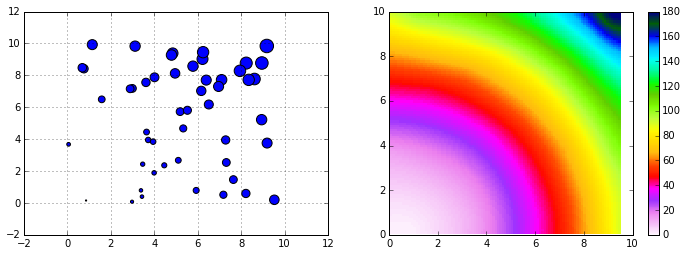

In [4]:
fig = plt.figure(figsize=(12, 4)); ax = fig.gca()
ax1=plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2=plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
ax1.scatter(x, y, z); ax1.grid()
CS = ax2.pcolor(gridx, gridy, out1, cmap=plt.cm.gist_ncar_r, vmin=0,vmax=180); plt.colorbar(CS)

# GIIPY11 Ba records

In [89]:
MAT = scipy.io.loadmat('_data/GIPY11_Ba')
lons = MAT['Ba_records'][:, 0]
lats = MAT['Ba_records'][:, 1]
deps = MAT['Ba_records'][:, 2]
Ba   = MAT['Ba_records'][:, 3]

** Get Ba @ surface **

In [91]:
hit = deps < 15
lon_surf = lons[hit]; lat_surf = lats[hit]; Ba_surf  = Ba[hit]
_, indices = np.unique(lon_surf, return_index=True)
x = lon_surf[indices]; y = lat_surf[indices]; z = Ba_surf[indices]
len(x)

36

36 points in total

**Kriging interpolation**

In [105]:
listx = np.linspace(x.min()*0.9, x.max()*1.1, 100)
listy = np.linspace(y.min(), 90, 100)
gridx, gridy = np.meshgrid(listx, listy)

In [106]:
OK = OrdinaryKriging(x, y, z, variogram_model='linear', verbose=False, enable_plotting=False)
Ba_int, ss = OK.execute('grid', listx, listy)

**Remap on ORCA2 frame**

In [ ]:
coordinate_name=glob.glob('_data/NEMO/ORCA2_INPUT/coordinates*.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]

In [ ]:
Ba_ini_orca = Nts.reporj_NEMOgrid(gridx, gridy, Ba_int, nav_lon, nav_lat, method='linear')

In [ ]:
hit = find_inland(nav_lon, nav_lat); Ba_ini_orca[hit==1]=np.nan
Ba_ini_masked = np.ma.masked_where(np.isnan(Ba_ini_orca), Ba_ini_orca)

# Plot

In [ ]:
ETOPO2_Arctic=scipy.io.loadmat('_libs/ETOPO2_Arctic.mat')
lon_arctic=ETOPO2_Arctic['lon_arctic']
lat_arctic=ETOPO2_Arctic['lat_arctic']
topo_arctic=ETOPO2_Arctic['topo_arctic']

In [ ]:
# Adjust resolution
res_unit=5
clevs=[1000, 2000, 3000]
lon_arctic=lon_arctic[0:-1:res_unit, 0:-1:res_unit]
lat_arctic=lat_arctic[0:-1:res_unit, 0:-1:res_unit]
topo_arctic=topo_arctic[0:-1:res_unit, 0:-1:res_unit]*-1

<matplotlib.colorbar.Colorbar instance at 0x7f98bc29aef0>

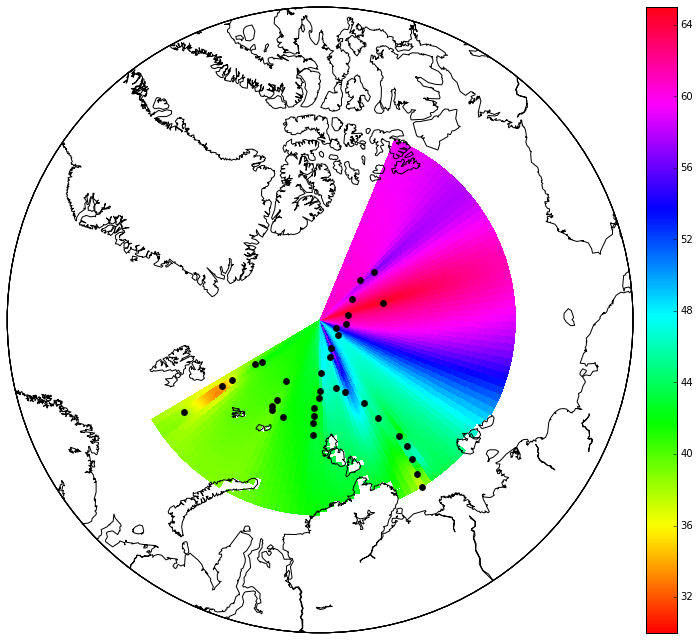

In [108]:
fig=plt.figure(figsize=(12, 12)); ax=plt.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=66.5, lon_0=90, round=True, ax=ax);
proj.drawcoastlines()
gridx, gridy = proj(nav_lon, nav_lat)
locx, locy = proj(x, y)
CS = proj.pcolor(gridx, gridy, Ba_ini_masked, vmin=30, vmax=65, cmap=plt.cm.hsv)
CS=proj.contour(x_topo, y_topo, topo_arctic, clevs, \
                linestyles='-', linewidths=1.5, colors=('k',), alpha=0.75)
proj.plot(gridx.T, gridy.T, 'k-')
proj.plot(gridx, gridy, 'k-')
proj.plot(locx, locy, 'ko'); proj.colorbar(CS)